# Finding Correct Learning Rate

#### Steps Done :
1. Data Preprocessing : Completed

#### Steps Ongoing : 
1. Finding correct learning rate

#### Architecture Used:
###### 1. densenet (with torchvision and fastai)

[1] fastai - Deep learning library developed by Howar, Gugger , Thomas

[2] torchvision - The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision

#### [3] densenet

![title](imjup/densenet_ar.png)

# Taking the clean images which we saved in Google Drive in Earlier Notebook
Authentication Establishment & Connecting with Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "drive/My Drive/Colab Notebooks/train.zip"

## Installing and Importing required libraries

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[1] if exists('/dev/nvidia0') else 'cpu'
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
  
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
    100% |████████████████████████████████| 696.4MB 21kB/s 
1.0.0.dev20190319
True
True
    100% |████████████████████████████████| 17.3MB 2.1MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

## Function to move files

In [ ]:
import shutil, os, glob
 
def moveAllFilesinDir(srcDir, dstDir):
    # Check if both the are directories
    if os.path.isdir(srcDir) and os.path.isdir(dstDir) :
        # Iterate over all the files in source directory
        for filePath in glob.glob(srcDir + '/*'):
            # Move each file to destination Directory
            shutil.move(filePath, dstDir);
    else:
        print("srcDir & dstDir should be Directories")

### Moving files to create required filesystem for training

In [ ]:
!mkdir tmp
!mkdir tmp/train
!mkdir tmp/train/0
!mkdir tmp/train/1
!mkdir tmp/train/2
!mkdir tmp/train/3
!mkdir tmp/train/4

moveAllFilesinDir('0', 'tmp/train/0')
moveAllFilesinDir('1', 'tmp/train/1')
moveAllFilesinDir('2', 'tmp/train/2')
moveAllFilesinDir('3', 'tmp/train/3')
moveAllFilesinDir('4', 'tmp/train/4')

#### Creating a Test folder from the Given Training Data

In [ ]:
!mkdir tmp/test
!mkdir tmp/test/0
!mkdir tmp/test/1
!mkdir tmp/test/2
!mkdir tmp/test/3
!mkdir tmp/test/4

In [ ]:
BASE_DIR = "tmp/train/"
NEW_DIR= "tmp/test/"

list_dir =  os.listdir(BASE_DIR)

for tdir in list_dir:
    list_images = os.listdir(BASE_DIR+tdir)
    to_val = random.sample(list_images, len(list_images)//5)
    for images in to_val:
        os.rename(BASE_DIR + str(tdir) + "/"+ images, NEW_DIR + str(tdir) + "/" + images )

In [0]:
!ls tmp

train  val


In [ ]:
print('Train Images')
!ls tmp/train/0 | wc -l
!ls tmp/train/1 | wc -l
!ls tmp/train/2 | wc -l
!ls tmp/train/3 | wc -l
!ls tmp/train/4 | wc -l

print('Test Images')
!ls tmp/test/0 | wc -l
!ls tmp/test/1 | wc -l
!ls tmp/test/2 | wc -l
!ls tmp/test/3 | wc -l
!ls tmp/test/4 | wc -l

# Making Machine Learning Model

In [0]:
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = densenet201                 # specify model architecture, densenet169 seems to perform well for this data but you could experiment
bs = 10 # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = 512                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

![title](imjup/densenet_rep.png)

In [0]:
PATH ='tmp/'
tfms = get_transforms(do_flip=True,max_zoom=1.3)

data = ImageDataBunch.from_folder('tmp',ds_tfms = tfms, valid='test', size=sz,bs=bs)

## Data Normalisation

By normalizing all of our inputs to a standard scale (-1,1), we're allowing the network to more quickly learn the optimal parameters for each input node.

In [ ]:
data.normalize(imagenet_stats)

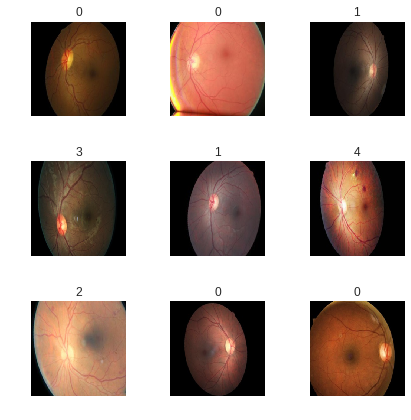

In [0]:
data.show_batch(rows=3, figsize=(6,6));

In [ ]:
def getLearner():
    return cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()

## Weight Decay

When training neural networks, it is common to use "weight decay," where after each update, the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large, and can be seen as gradient descent on a quadratic regularization term.

## Finding the correct Learning Rate 

In [0]:
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() 

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() 

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


## Plot weight decays

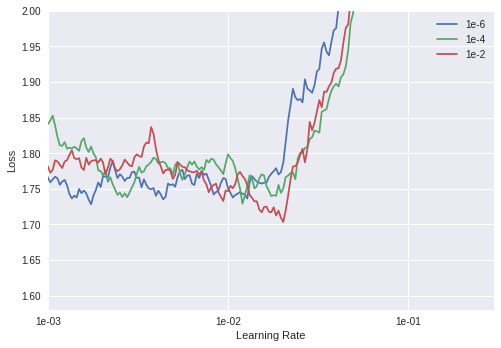

In [0]:
_, ax = plt.subplots(1,1)
min_y = 1.6
max_y = 2
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate") 
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

## Analysis

#### 1. Losses came down most with weight decay 1e-2 and optimal learning rate around 1e-2 but it looks unstable as its keep going up and down
#### 2. Best Learning rate should lie around 1e-3 and weight decay 1e-6 looks really stable

#### max_lr = 1e-3 && wd = 1e-6